In [2]:
# New version: FA 2023 Jan 31

# Predicting ages from spectroscopic abundances with XGBoost 

In [1]:
import numpy as np #numpy
import pandas as pd
import matplotlib.pyplot as plt  #matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table  #astropy
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde  #scipy: science python
import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [2]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


There is also a column informing about the evolutionary state (RC / RGB):

In [3]:
mig['evstate']

0       1
1       1
2       1
3       1
4       1
       ..
3310    2
3311    1
3312    1
3313    1
3314    2
Name: evstate, Length: 3315, dtype: int32

We'll also have a look at the APOGEE DR17 abundance flags:

In [4]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

RV_FLAG
0     3314
32       1
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      3314
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      3312
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      3272
256      37
288       6
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    3315
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      3311
256       3
1         1
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    3315
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0    3315
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    3315
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      3270
258      30
0         8
3         4
259       3
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      3314
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      3313
1         1
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    3315
Name: CA_FE_FLAG, dtype: int64

TI_FE_FLAG
0    3315
Name: TI_FE_FLAG, dtype: int64

TIII_FE_FLAG
0      3307
257       4
256       3
1         1
Name: TIII_FE_FLAG, dtype: int64


## Data selection criteria

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [5]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TIII_FE_FLAG'] == 0)& \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)]

In [6]:
print(len(mig), "suffice the FLAG conditions")

3250 suffice the FLAG conditions


## Some plots (overplotting the training set over the full APOGEE DR17 data):
First read the DR17 table:

In [7]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


### $T_{\rm eff}-\log g$ diagram

In [9]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Dec2022.fits")
chem_age = np.isfinite(dr17_master['Chemical_Age_Dec2022'])

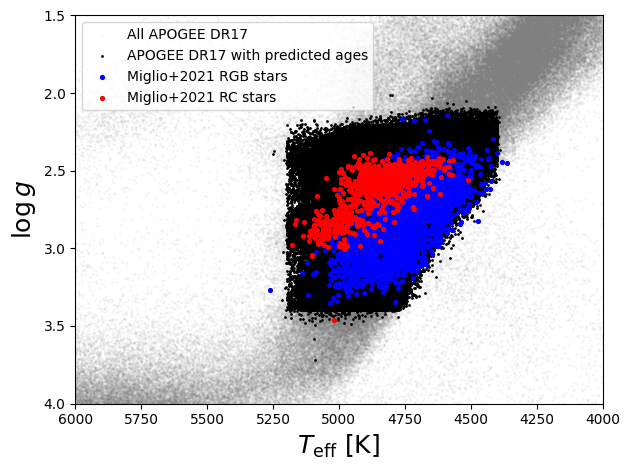

In [10]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.05, s=1, label="All APOGEE DR17")
plt.scatter(dr17_master['TEFF'][chem_age], dr17_master['LOGG'][chem_age], c="k", s=1, label="APOGEE DR17 with predicted ages")
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.axis([6000, 4000, 4, 1.5])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("../im/kiel_diagram.png")

### Age uncertainties of the Miglio+2021 sample

Median rel. age uncertainty for RGB: 0.22727275
Median rel. age uncertainty for RC: 0.097561


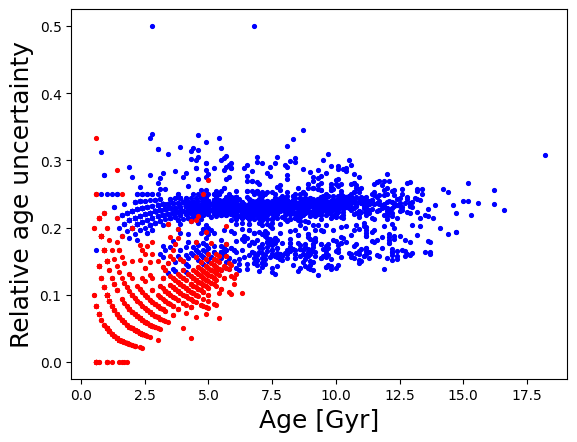

In [11]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png")

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

## Galactic distribution

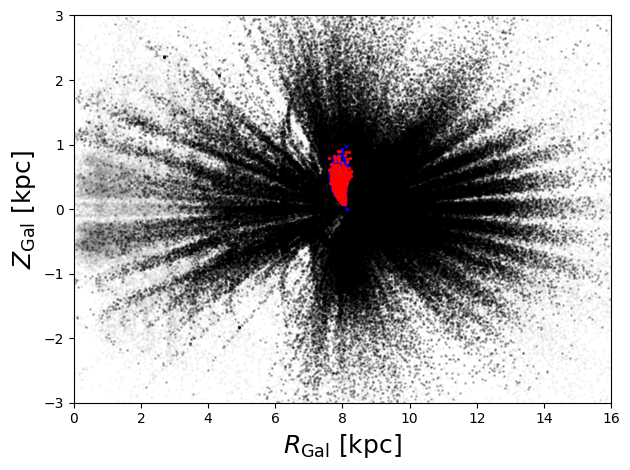

In [12]:
plt.scatter(dr17_master['Rg'], dr17_master['Zg'], c="grey", alpha=0.05, s=1, label="APOGEE DR17")
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=0.2, label="APOGEE DR17")
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=2, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=2, c="red", label="Miglio+2021 RC stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all.png")

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [13]:
filtered_df = mig[['Age',   'TEFF',  'LOGG', 
                   'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
                   'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
                   'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
                   'CO_FE', 'NI_FE' ]].copy() # excluding: ['FE_H', 'CE_FE']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [14]:
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583
5,10.0,4684.613281,2.848780,0.104613,0.138510,0.141330,0.223403,0.108262,0.297463,0.224611,0.378678,0.103955,0.120173,-0.176968,-0.106488,0.13391,0.124313


In [15]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Train XGBoost

Test if the algorithm works:

In [16]:
filename = './models/test_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 10, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.499214
Score: 0.8057988132789198


### Run gridsearch to optimise the hyperparameters:
Running the following cell takes a while (30 min on my computer)... so it's not recommended to run it unless you really need it.

### Run the algorithm with optised hyperparameters:

In [17]:
filename = './models/default_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 500, learning_rate = 0.02,
                             max_depth = 5, min_child_weight = 4, 
                             subsample = 0.7, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.368546
Score: 0.8381759006136705


### Separate models for RGB and RC?

In [18]:
# Define a function that does the magic:

def xgboost(filtered_df):
    # Split dataframe into input and output columns
    y = filtered_df['Age']
    X = filtered_df.drop(columns = 'Age')
    
    # Splitting into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                          test_size = 0.2, random_state = 123)
      
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 500, learning_rate = 0.02,
                             max_depth = 5, min_child_weight = 4, 
                             subsample = 0.7, seed = 123)    
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    return model, test_y, pred

In [19]:
# Consider fitting RGBs and RCs separately:
rgbs = filtered_df[mig["evstate"]==1]
rcs  = filtered_df[mig["evstate"]==2]
model_rgb, test_rgb, pred_rgb = xgboost(rgbs)
model_rc,  test_rc,  pred_rc  = xgboost(rcs)
# Save these models:
pickle.dump(model_rgb, open('./models/rgb_model.pkl', 'wb'))
pickle.dump(model_rc,  open('./models/rc_model.pkl',  'wb'))

/tmp/ipykernel_576569/957178277.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rgbs = filtered_df[mig["evstate"]==1]
/tmp/ipykernel_576569/957178277.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rcs  = filtered_df[mig["evstate"]==2]


# Plots

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


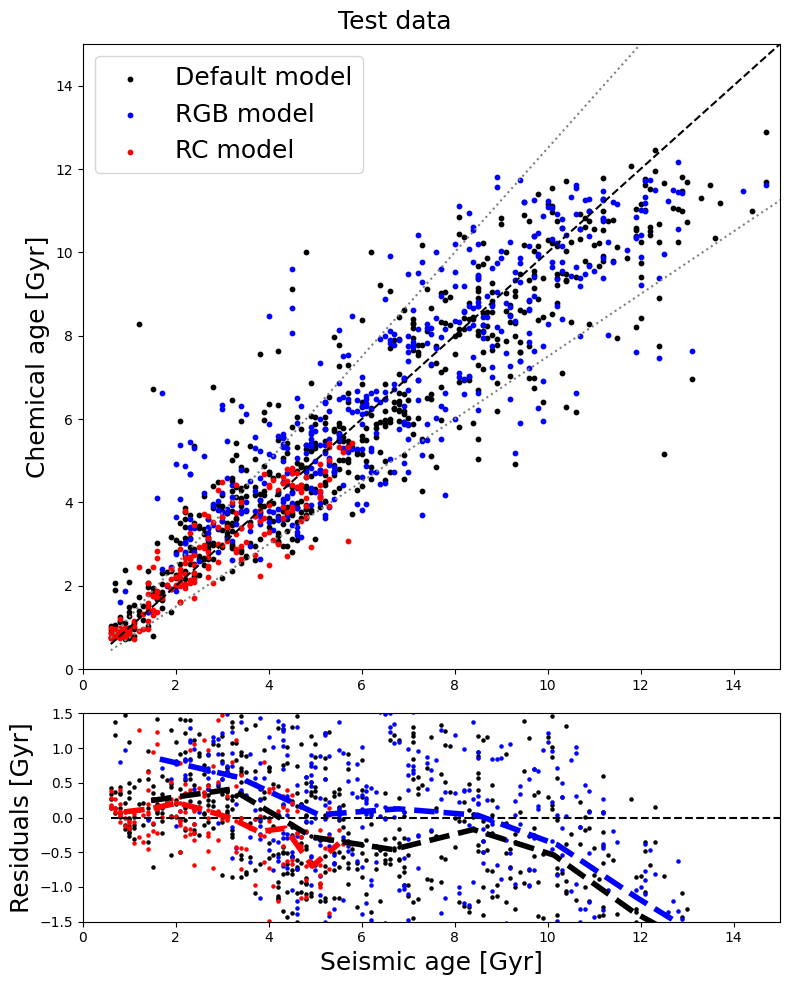

In [22]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

# Top panel: predicted age vs. seismic age
a0.scatter(test_y, pred, c="k", s=10, label="Default model")
a0.scatter(test_rgb, pred_rgb, c="b", s=10, label="RGB model")
a0.scatter(test_rc,  pred_rc, c="r", s=10, label="RC model")
xx = np.linspace(np.min(test_y), np.max(test_y), 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Chemical age [Gyr]", fontsize=18)
a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])

# Bottom panel: residuals
a1.scatter(test_y, pred-test_y, c="k", s=5)
a1.scatter(test_rgb, pred_rgb-test_rgb, c="b", s=5)
a1.scatter(test_rc,  pred_rc-test_rc, c="r", s=5)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

# Overplot running median
def running_median(X, Y, nbins=10):
    bins = np.linspace(X.min(),X.max(), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins)
    running_median = [np.median(Y[idx==k]) for k in range(nbins)]
    return bins - delta/2, running_median

med_all_x, med_all_y = running_median(test_y, pred-test_y, nbins=10)
a1.plot(med_all_x, med_all_y,'k--',lw=4)
med_rgb_x, med_rgb_y = running_median(test_rgb, pred_rgb-test_rgb, nbins=10)
a1.plot(med_rgb_x, med_rgb_y,'b--',lw=4)
med_rc_x, med_rc_y = running_median(test_rc,  pred_rc-test_rc, nbins=10)
a1.plot(med_rc_x, med_rc_y,'r--',lw=4)

a1.axis([0,15,-1.5, 1.5])
plt.suptitle("Test data", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata.png")

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


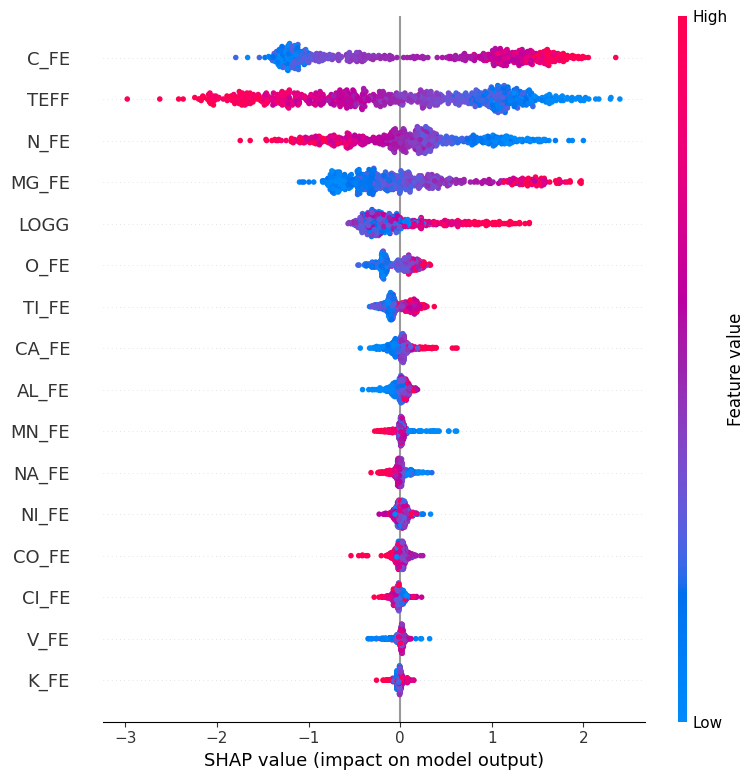

In [31]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
plt.savefig("../im/shap_beeswarm.png")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


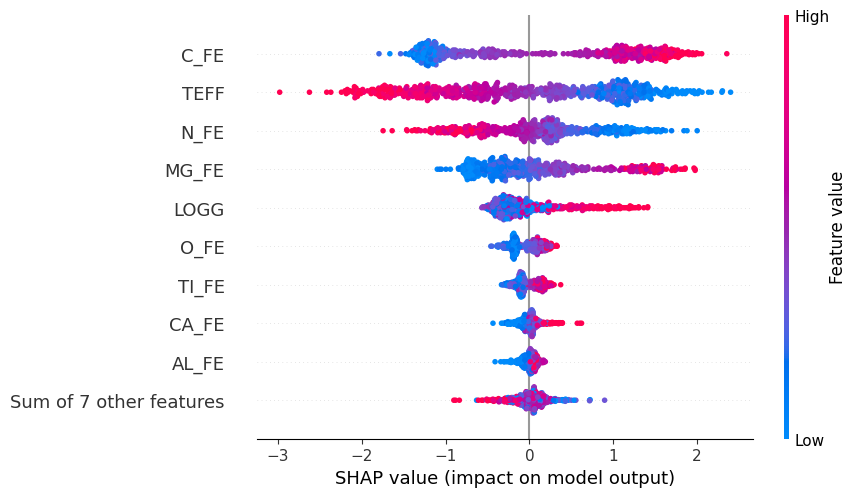

In [24]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

# XGBOOST WITH PERTURBED DATA

In [18]:
mig = mig.reset_index()
mig  = mig.drop(columns = 'index')
rmse_list = []
score_list = []
for ii in np.arange(10):
    # Run XGBoost with slightly perturbed input data
    #Hem de transformar els train sets
    C_FE_2 = []
    CI2 = []
    N2 = []
    O2 = []
    na2 = []
    mg2 = []
    ti2 = []
    for row in range(len(mig)):
        #C_FE
        err_C = mig['C_FE_ERR'][row]
        val_C = mig['C_FE'][row]
        C2 = float(val_C) + np.random.normal(0, float(err_C))
        C_FE_2.append(C2)
        #CI_FE
        err_CI = mig['CI_FE_ERR'][row]
        val_CI = mig['CI_FE'][row]
        CI2_v = float(val_CI) + np.random.normal(0, float(err_CI))
        CI2.append(CI2_v)
        #N_FE
        err_N = mig['N_FE_ERR'][row]
        val_N = mig['N_FE'][row]
        N_v = float(val_N) + np.random.normal(0, float(err_N))
        N2.append(N_v)
        #O_FE
        err_o = mig['O_FE_ERR'][row]
        val_o = mig['O_FE'][row]
        O_v = float(val_o) + np.random.normal(0, float(err_o))
        O2.append(O_v)
        #NA_FE
        err_na = mig['NA_FE_ERR'][row]
        val_na = mig['NA_FE'][row]
        na_v = float(val_na) + np.random.normal(0, float(err_na))
        na2.append(na_v)
        #MG_FE
        err_mg = mig['MG_FE_ERR'][row]
        val_mg = mig['MG_FE'][row]
        mg_v = float(val_mg) + np.random.normal(0, float(err_mg))
        mg2.append(mg_v)
        #TI_FE
        err_ti = mig['TI_FE_ERR'][row]
        val_ti = mig['TI_FE'][row]
        ti_v = float(val_ti) + np.random.normal(0,float(err_ti))
        ti2.append(ti_v)
    mig['C_FE_2'] = C_FE_2
    mig['CI_FE_2'] = CI2
    mig['N_FE_2'] = N2
    mig['O_FE_2']= O2
    mig['NA_FE_2']= na2
    mig['MG_FE_2'] = mg2
    mig['TI_FE_2'] = ti2
    filtered_df = mig[['Age','TEFF','LOGG', 'C_FE_2', 'CI_FE_2', 'N_FE_2', 'O_FE_2', 'NA_FE_2', 'MG_FE_2',
                  'TI_FE_2']].copy() #He de escollir una age, teff, logg amb error? Quin error fico?
    filtered_df = filtered_df.dropna()
    filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')
    # Split dataframe into input and output columns
    y = filtered_df['Age']
    X = filtered_df.drop(columns = 'Age')

    # Splitting into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)
  
    # Instantiation
    modeli = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123) #Hem canviat per reg:linear a squared error per warning deprecation
  
    # Fitting the model
    modeli.fit(train_X, train_y)
    
    # Predict the model
    pred = modeli.predict(test_X)
  
    # RMSE Computation
    rmse = np.sqrt(MSE(test_y, pred))
    rmse_list.append(rmse)   

    #Score
    result = modeli.score(test_X, test_y)
    score_list.append(result)

df_results = pd.DataFrame({'RMSE': rmse_list, 'Score':score_list})
df_results

,RMSE,Score
0,1.400984,0.811596
1,1.413038,0.808339
2,1.422377,0.805798
3,1.416294,0.807455
4,1.407068,0.809956
5,1.465664,0.793798
6,1.399020,0.812123
7,1.440727,0.800755
8,1.432501,0.803023
9,1.400715,0.811668


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


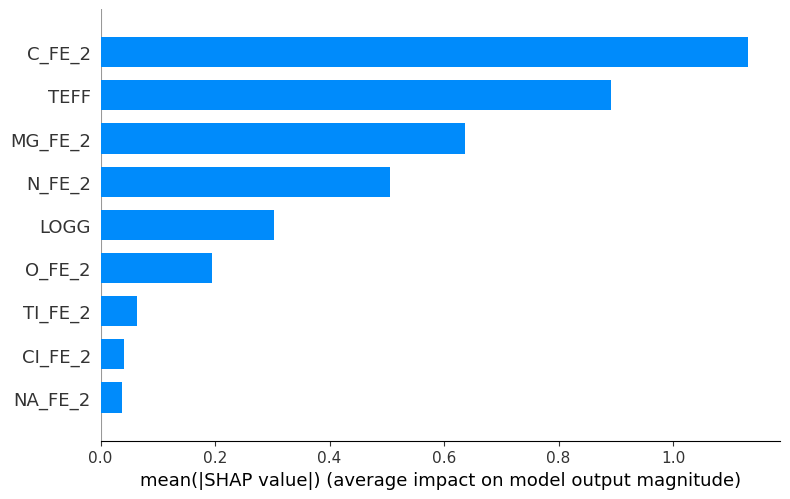

In [19]:
#Fem un shap values de la ultima iteracio per veure que tal
import shap
# Fits the explainer
explainer = shap.Explainer(modeli)
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, plot_type="bar")

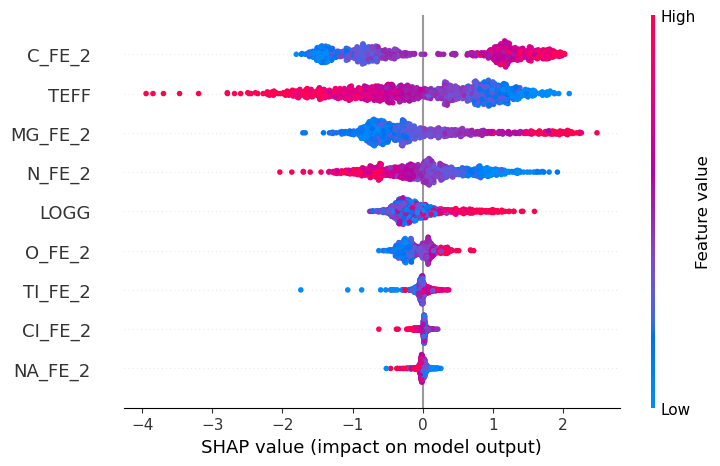

In [20]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

# Import the APOGEE DR17 table

This file is BIG so it's not included in the data folder. Even the light version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits


No tenim la columna age, hem de calcularho nosaltres

In [26]:
big = big[(big['TEFF'] < 5200)&(big['TEFF'] > 4400)]
big = big[(big['LOGG'] < 3.4)&(big['LOGG'] > 2.2)]
big = big[big['TEFF_ERR'] < 150]
big = big[(big['RV_FLAG'] == 0)&(big['C_FE_FLAG'] == 0)&(big['CI_FE_FLAG'] == 0)&(big['N_FE_FLAG'] == 0)&(big['O_FE_FLAG'] == 0)&(big['NA_FE_FLAG'] == 0)&
         (big['S_FE_FLAG'] == 0)&(big['TIII_FE_FLAG'] == 0)&(big['V_FE_FLAG'] == 0)&(big['CE_FE_FLAG'] == 0)]

Text(0.5, 1.0, 'LOGG(TEFF)')

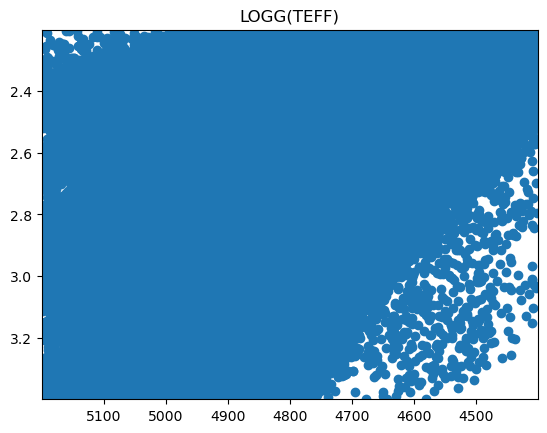

In [27]:
import numpy as np
import matplotlib.pyplot as plt
x = big['TEFF']
y = big['LOGG']
plt.scatter(x,y)
plt.xlim(max(x), min(x))
plt.ylim(max(y), min(y))
plt.title('LOGG(TEFF)')

Ok tenim moltes dades

In [30]:
filtered_big = big[['TEFF','LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'S_FE', 'K_FE', 'CA_FE',
                  'TI_FE', 'V_FE', 'CR_FE', 'MN_FE', 'FE_H', 'CO_FE', 'NI_FE', 'CE_FE' ]].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

In [32]:
# Predict the model
pred = model.predict(filtered_big)

In [36]:
pred = pred.tolist()

In [37]:
filtered_big['Predicted_Ages'] = pred

Text(0.5, 1.0, '[Fe/H](isocronic age)')

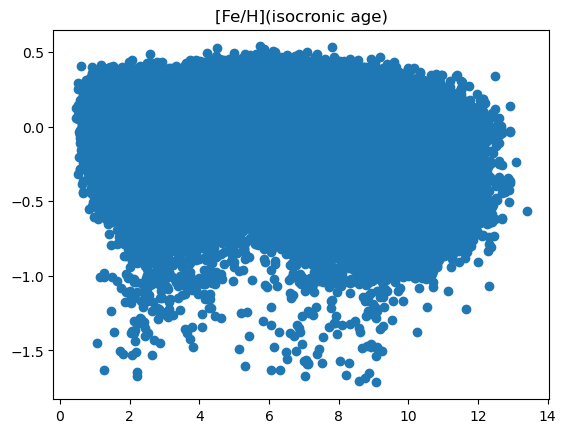

In [38]:
x = filtered_big['Predicted_Ages']
y = filtered_big['FE_H']
plt.scatter(x,y)
plt.title('[Fe/H](isocronic age)')